In [1]:
import Utilities.prelude
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from scipy.optimize import fsolve
import pickle 

from src.shock_zone import shock_direction, find_prepost
from Utilities.operators import make_tree, calc_grad

# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [2]:
mach_min = 1.3
save = True
folder = 'sedov'
snap = '100'
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    threshold = 7_000
else:
    is_tde = False
    threshold = 0.99

In [3]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, delta, direction):
    point = np.array([x_zone[idx], y_zone[idx], z_zone[idx]])
    div_v = div[idx]
    dir_sh = np.array(dir[idx])
    
    check_zone = True # to check if the new point is in the shock zone
    while check_zone == True:
        i_tree = find_prepost(sim_tree, X, Y, Z, point, dir_sh, delta, direction)

        # find the nearest points in the grid and in the shock zone
        check_zone = are_u_shock[i_tree]

        if check_zone == True:
            # dumb way 
            idx_zone = np.argmin(np.abs(i_tree-all_idx))
            idx_zone = int(idx_zone)
            div_next = div[idx_zone]
            dir_next = dir[idx_zone]

            # if lower div v, you discard the ray.
            if div_next < div_v:
                return False # and then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = False # so you exit from the while

        point = np.array([X[i_tree], Y[i_tree], Z[i_tree]])
 
    final_tree_index = i_tree
    
    return final_tree_index

def shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, all_idx, div, dir, delta):
    surface_mach = []
    surface_Pmach = []
    surface_Denmach = []
    surface_x = []
    surface_y = []
    surface_z = []
    post_x = []
    post_y = []
    post_z = []
    pre_x = []
    pre_y = []
    pre_z = []
    dir_x = []
    dir_y = []
    indeces = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        # print(idx)
        post_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, delta, direction = 'post')
        if post_tree_index == False:
            continue
        else:
            Tpost = Temp[post_tree_index]
            pre_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, delta, direction = 'pre')
            if pre_tree_index == False:
                continue
            else:
                Tpre = Temp[pre_tree_index]

                Tbump = Tpost/Tpre
                # check if the Tbump is in the same direction of ds. CHECK THIS
                if Tbump < 1:
                    continue 

                surface_x.append(x_zone[idx])
                surface_y.append(y_zone[idx])
                surface_z.append(z_zone[idx])
                post_x.append(X[post_tree_index])
                post_y.append(Y[post_tree_index])
                post_z.append(Z[post_tree_index])
                pre_x.append(X[pre_tree_index])
                pre_y.append(Y[pre_tree_index])
                pre_z.append(Z[pre_tree_index])
                dir_x.append(dir[idx][0])
                dir_y.append(dir[idx][1])
                indeces.append(idx)

                def temperature_bump(mach):
                    gamma = 5/3
                    to_solve =  ((gamma-1) * mach**2 + 2) * (2 * gamma * mach**2 - (gamma-1)) / ((gamma+1)**2 * mach**2) - Tbump
                    to_solve = float(to_solve)
                    return to_solve
                
                Ppre = Press[pre_tree_index]
                Ppost = Press[post_tree_index]
                Pbump = Ppost/Ppre
                Denpre = Den[pre_tree_index]
                Denpost = Den[post_tree_index]
                Denbump = Denpost/Denpre

                def pressure_bump(mach):
                    gamma = 5/3
                    to_solveP = (2 * gamma * mach**2 - (gamma-1)) / (gamma+1) - Pbump
                    return to_solveP

                def density_bump(mach):
                    gamma = 5/3
                    to_solverho = (gamma+1) * mach**2 / (mach**2 * (gamma-1) + 2) - Denbump
                    return to_solverho
                
                mach = fsolve(temperature_bump, 1.5)
                Pmach = fsolve(pressure_bump, 1.5)
                Denmach = fsolve(density_bump, 1.5)

                surface_mach.append(mach)
                surface_Pmach.append(Pmach)
                surface_Denmach.append(Denmach)

            
    surface_mach = np.array(surface_mach)
    surface_Pmach = np.array(surface_Pmach)
    surface_Denmach = np.array(surface_Denmach)

    surface_x = np.array(surface_x)
    surface_y = np.array(surface_y)
    surface_z = np.array(surface_z)
    post_x = np.array(post_x)
    post_y = np.array(post_y)
    post_z = np.array(post_z)
    pre_x = np.array(pre_x)
    pre_y = np.array(pre_y)
    pre_z = np.array(pre_z)
    dir_x = np.array(dir_x)
    dir_y = np.array(dir_y)
    indeces = np.array(indeces)

    return surface_mach, surface_Pmach, surface_Denmach, surface_x, surface_y, surface_z, post_x, post_y, post_z, pre_x, pre_y, pre_z, dir_x, dir_y, indeces


In [4]:
# Import data
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')
shockdir = np.loadtxt(f'data/{snap}/shockdir_{snap}.txt')

x_zone = np.array(shockzone[0])
y_zone = shockzone[1]
z_zone = shockzone[2]
div = shockzone[3]
Tzone = shockzone[4]
idx_tree = shockzone[5]

x_dir = shockdir[0]
y_dir = shockdir[1]
z_dir = shockdir[2]
dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [5]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

all T=0, bro. Compute by myself!


In [6]:
step = 2 * np.min(dim_cell)

In [7]:
with open(f'data/{snap}/shockbool_{snap}.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)

In [8]:
surface_mach, surface_Pmach, surface_Denmach, surface_x, surface_y, surface_z, post_x, post_y, post_z, pre_x, pre_y, pre_z, dir_x, dir_y, indeces = shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, idx_tree, div, dir, step)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_11305/3582115374.py:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  to_solve = float(to_solve)


815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051


In [9]:
if save == True:
    surface_mach_txt = np.concatenate(surface_mach)
    with open(f'data/{snap}/shocksurface_{snap}.txt', 'w') as file:
        file.write(f'# Coordinates of the points in the shock surface \n# X \n') 
        file.write(' '.join(map(str, surface_x)) + '\n')
        file.write('# Y \n') 
        file.write(' '.join(map(str, surface_y)) + '\n')
        file.write('# Z \n') 
        file.write(' '.join(map(str, surface_z)) + '\n')
        file.write('# mach number \n') 
        file.write(' '.join(map(str, surface_mach_txt)) + '\n')
        file.write('# indeces \n') 
        file.write(' '.join(map(str, indeces)) + '\n')
        file.close()

In [10]:
outlier = np.argmin(surface_mach)
print(outlier)

830


In [11]:
epsilon = 0.02
z_chosen = 0#surface_z[outlier]

In [12]:
# Cross section
if folder == 'sedov':
    slice_zone = np.logical_and(z_zone<z_chosen+epsilon, z_zone>z_chosen-epsilon)
    zone_cross_x = x_zone[slice_zone]
    zone_cross_y = y_zone[slice_zone]

    slice_surface = np.logical_and(surface_z<z_chosen+epsilon, surface_z>z_chosen-epsilon)
    surface_cross_x = surface_x[slice_surface]
    surface_cross_y = surface_y[slice_surface]

    cross_shockdirx = dir_x[slice_surface]
    cross_shockdiry = dir_y[slice_surface]

    slice_post = np.logical_and(post_z<z_chosen+epsilon, post_z>z_chosen-epsilon)
    zone_post_x = post_x[np.logical_and(slice_surface, slice_post)] # post_x[slice_surface] 
    zone_post_y = post_y[np.logical_and(slice_surface, slice_post)] # post_y[slice_surface]

    slice_pre = np.logical_and(pre_z<z_chosen+epsilon, pre_z>z_chosen-epsilon)
    zone_pre_x = pre_x[np.logical_and(slice_surface, slice_pre)] # pre_x[slice_surface]
    zone_pre_y = pre_y[np.logical_and(slice_surface, slice_pre)] # pre_y[slice_surface]


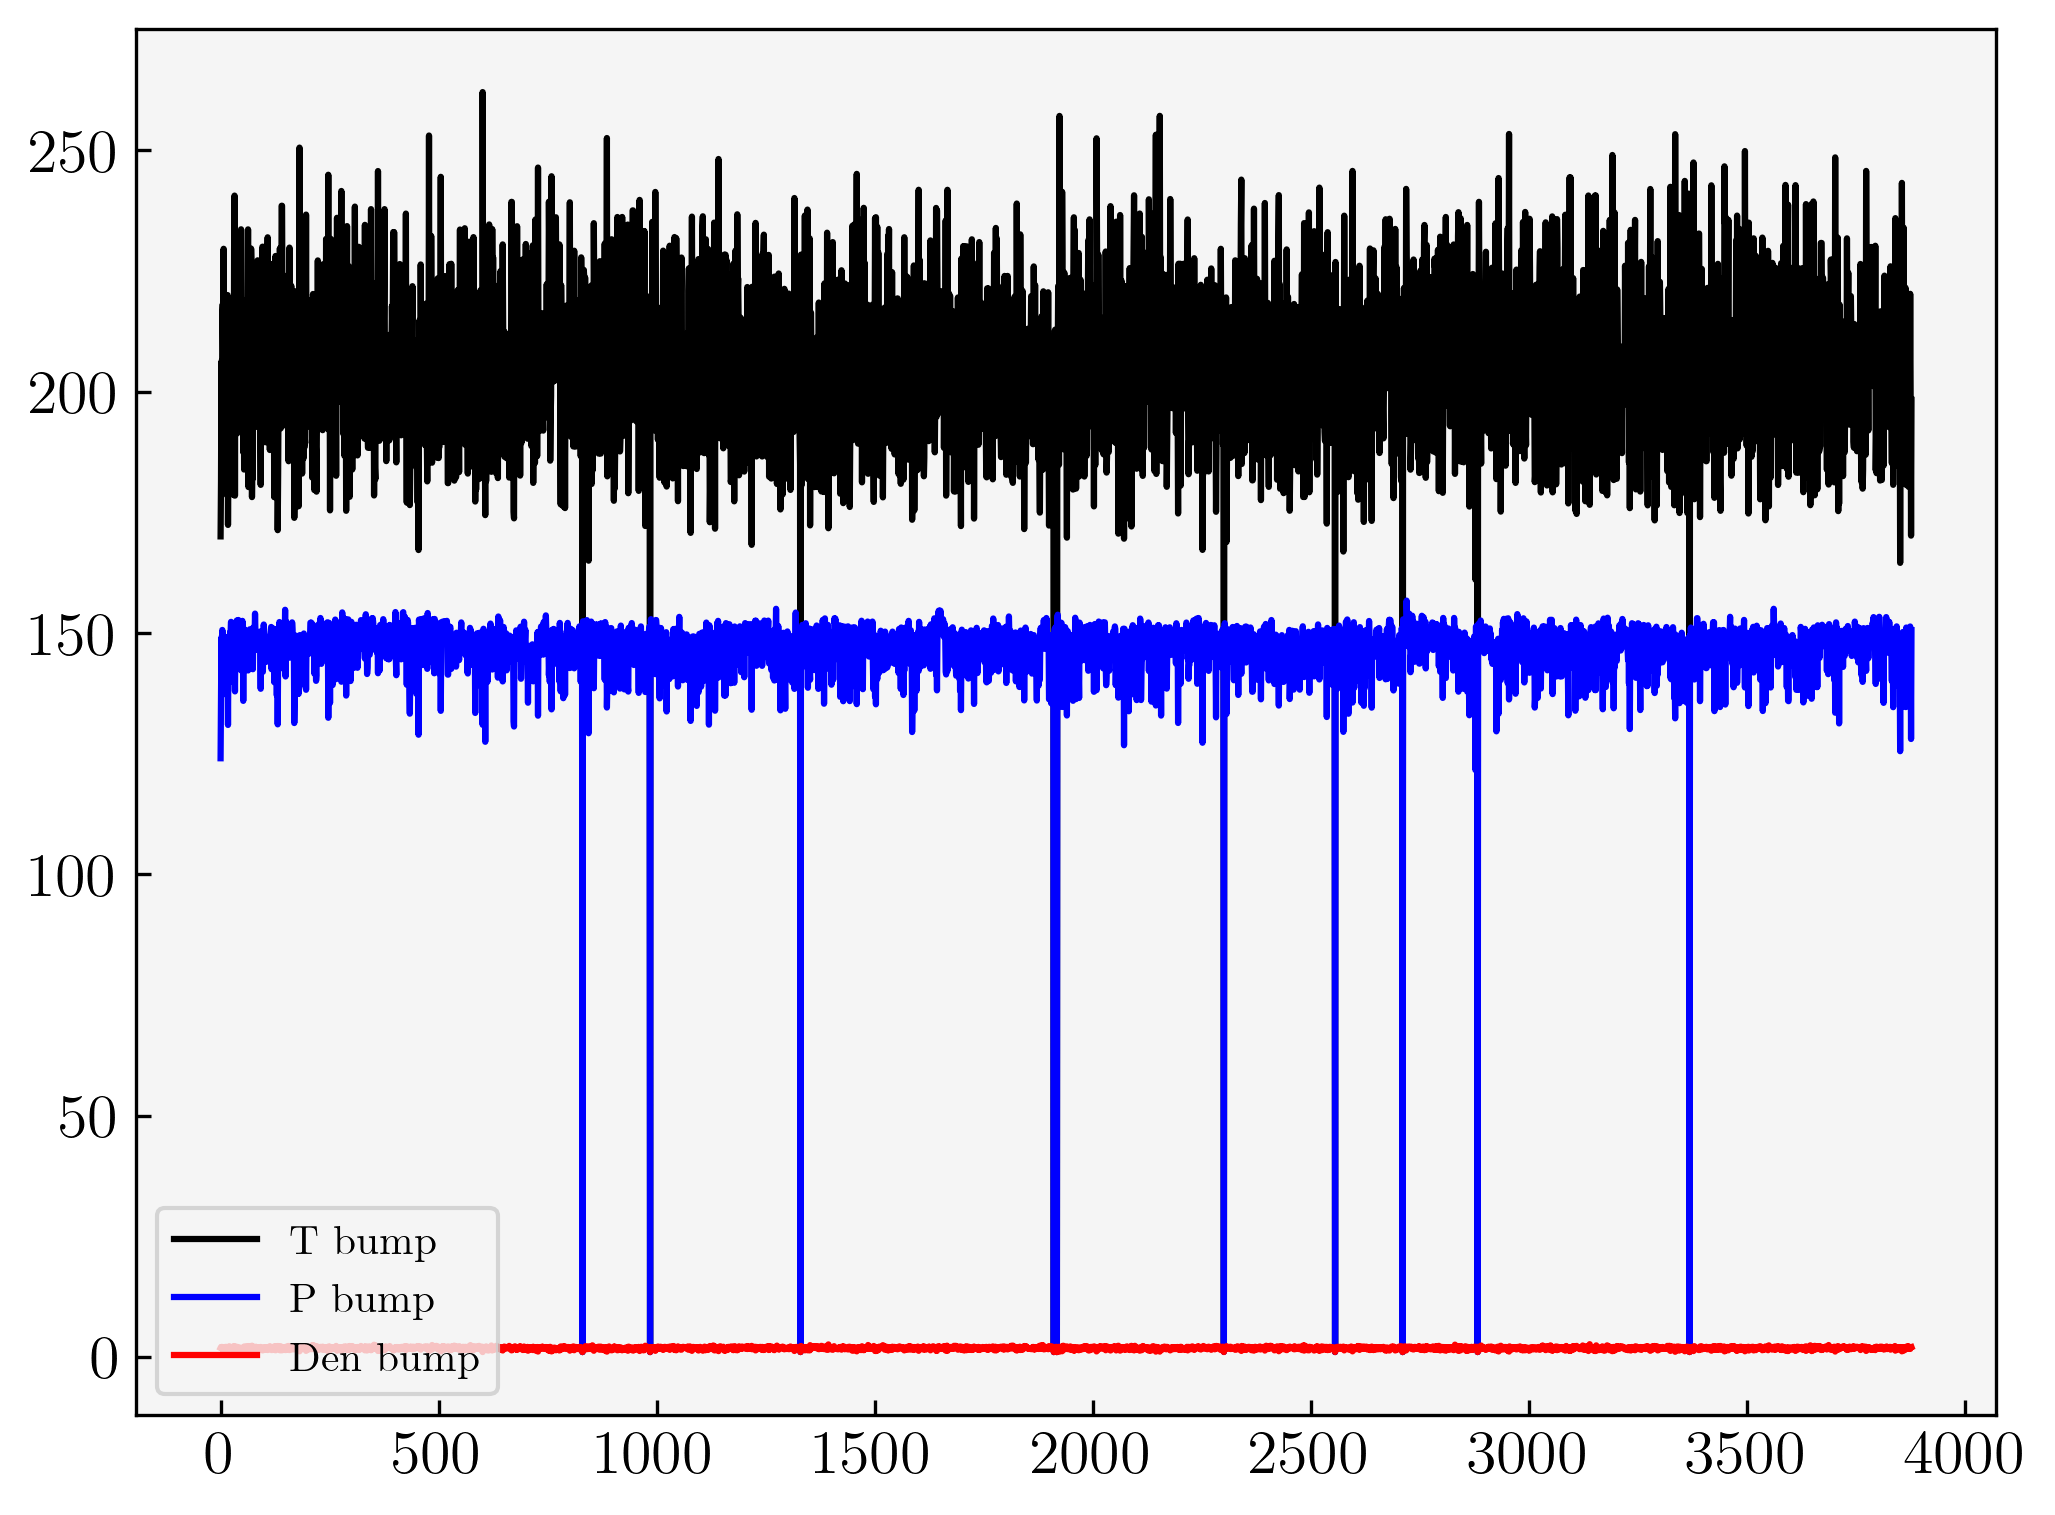

In [20]:
plt.plot(surface_mach, c = 'k', label = 'T bump')
plt.plot(surface_Pmach, c = 'b', label = 'P bump')
plt.plot(surface_Denmach, c = 'r', label = 'Den bump')
plt.legend(loc = 'lower left')

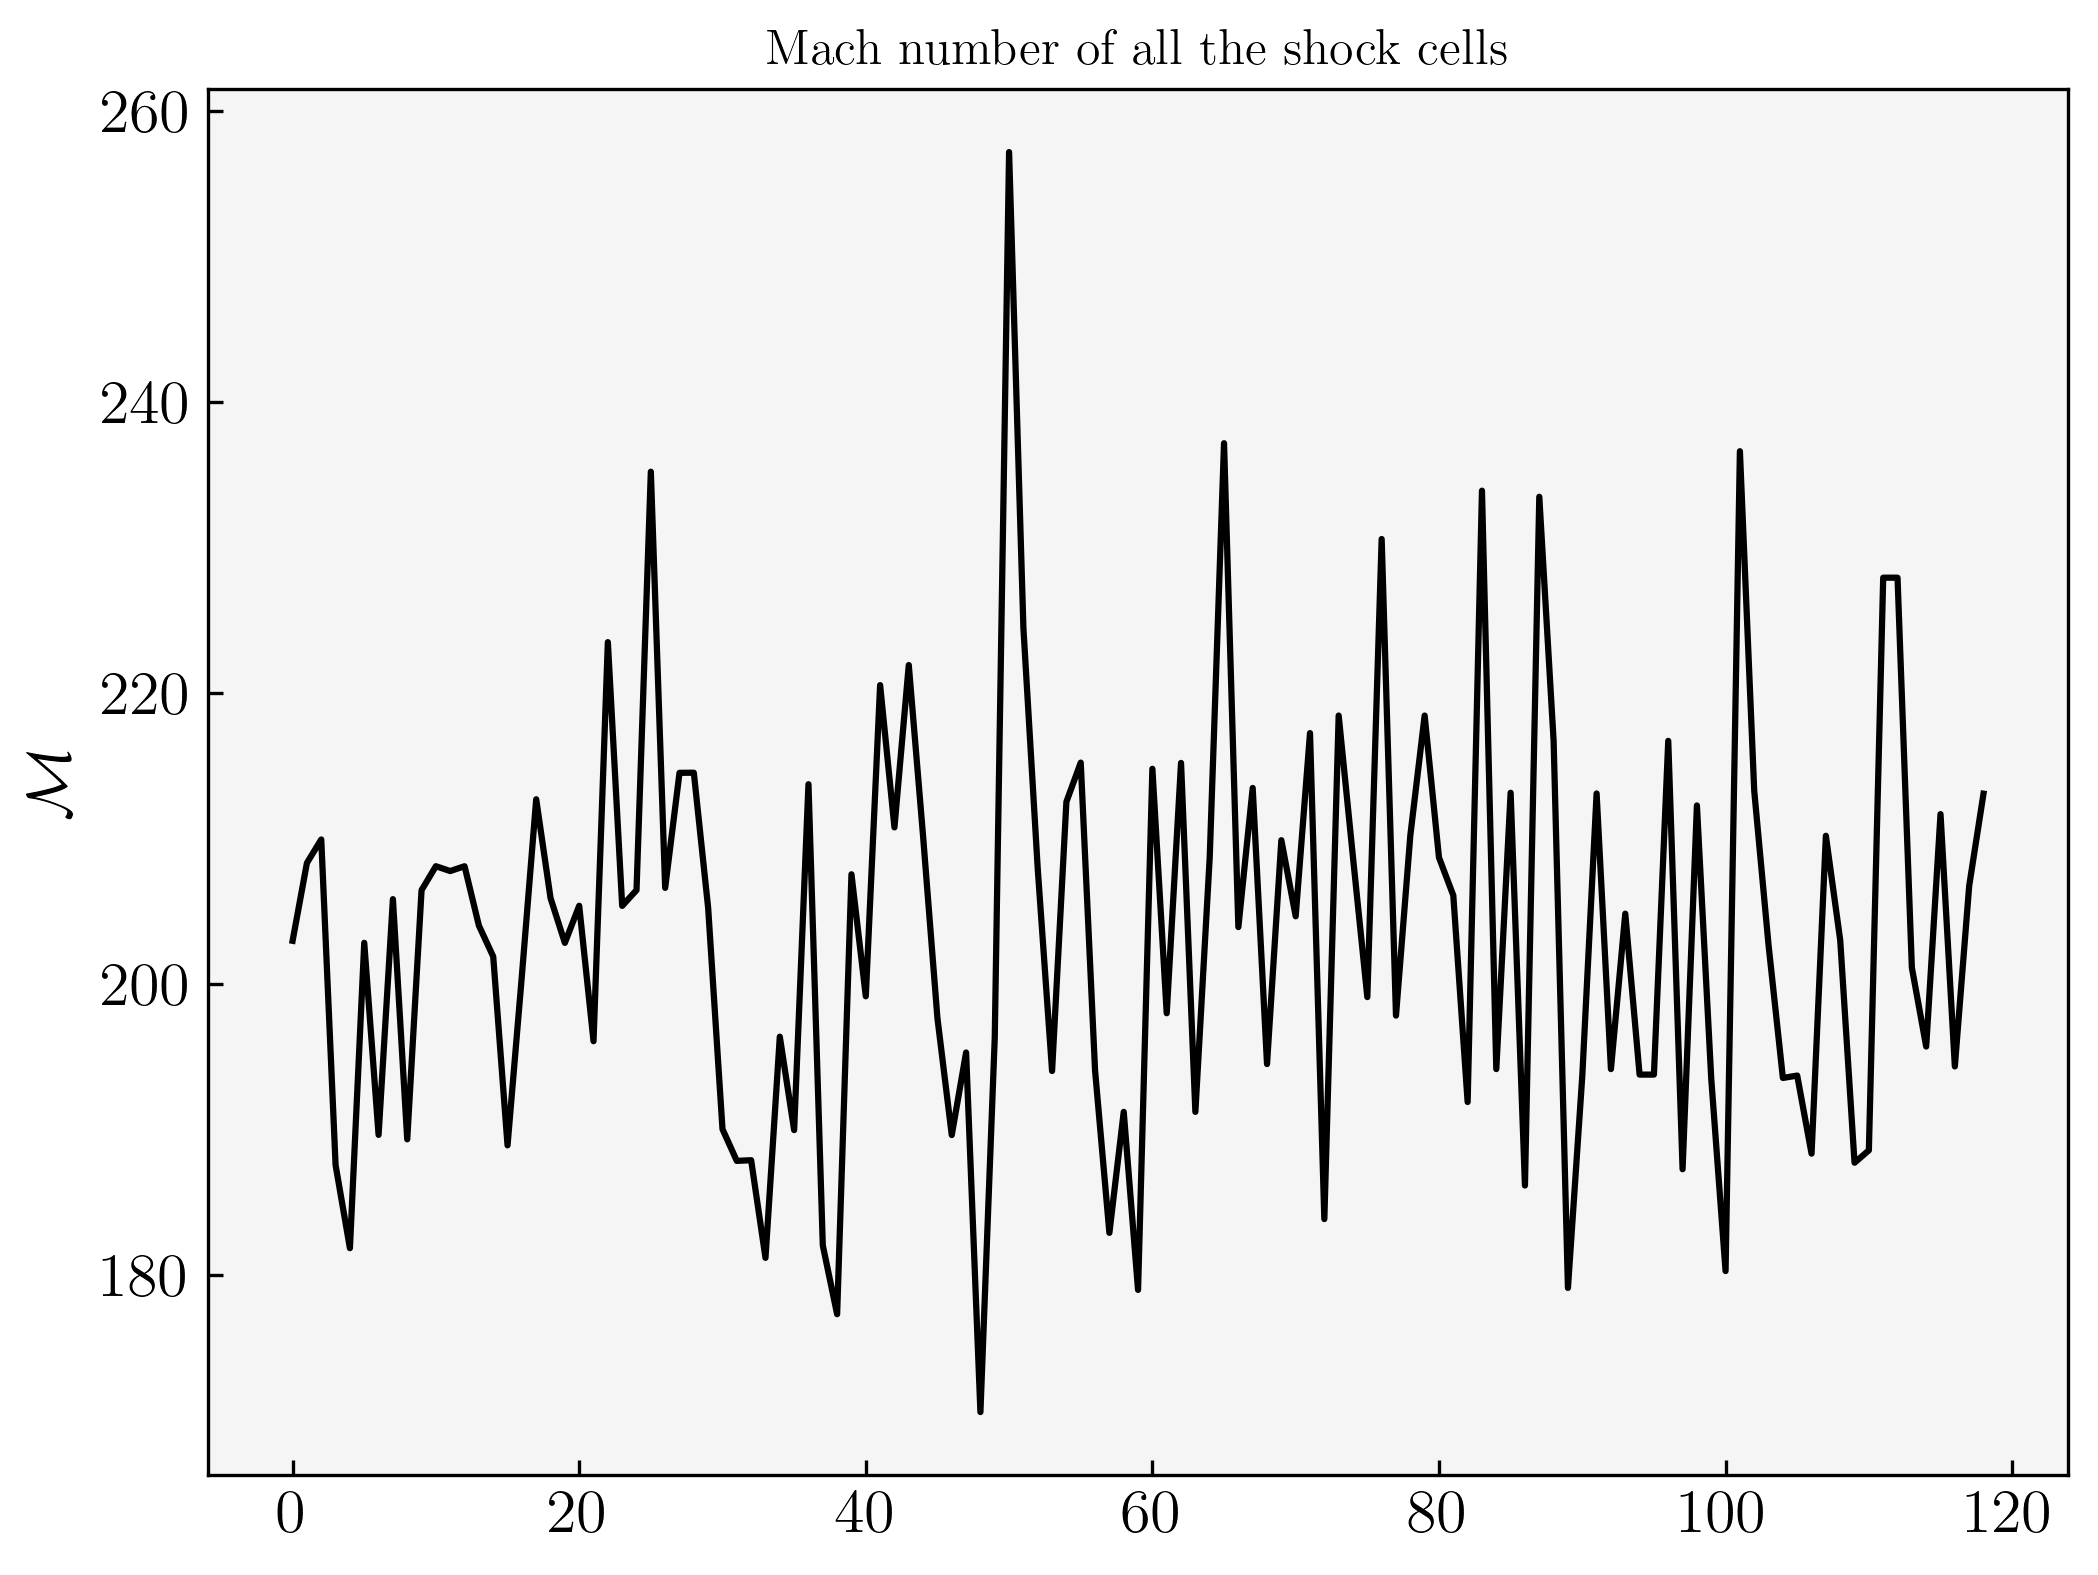

In [14]:
plt.plot(surface_mach[slice_surface], c = 'k')
# plt.scatter(outlier, surface_mach[np.logical_and(surface_z<z_chosen+step, surface_z>z_chosen-step)][outlier], c = 'r')
plt.ylabel(r'$\mathcal{M}$', fontsize = 15)
plt.title('Mach number of all the shock cells')
if save == True:
  plt.savefig(f'Figs/{snap}/6mach_{snap}.png')
plt.show()

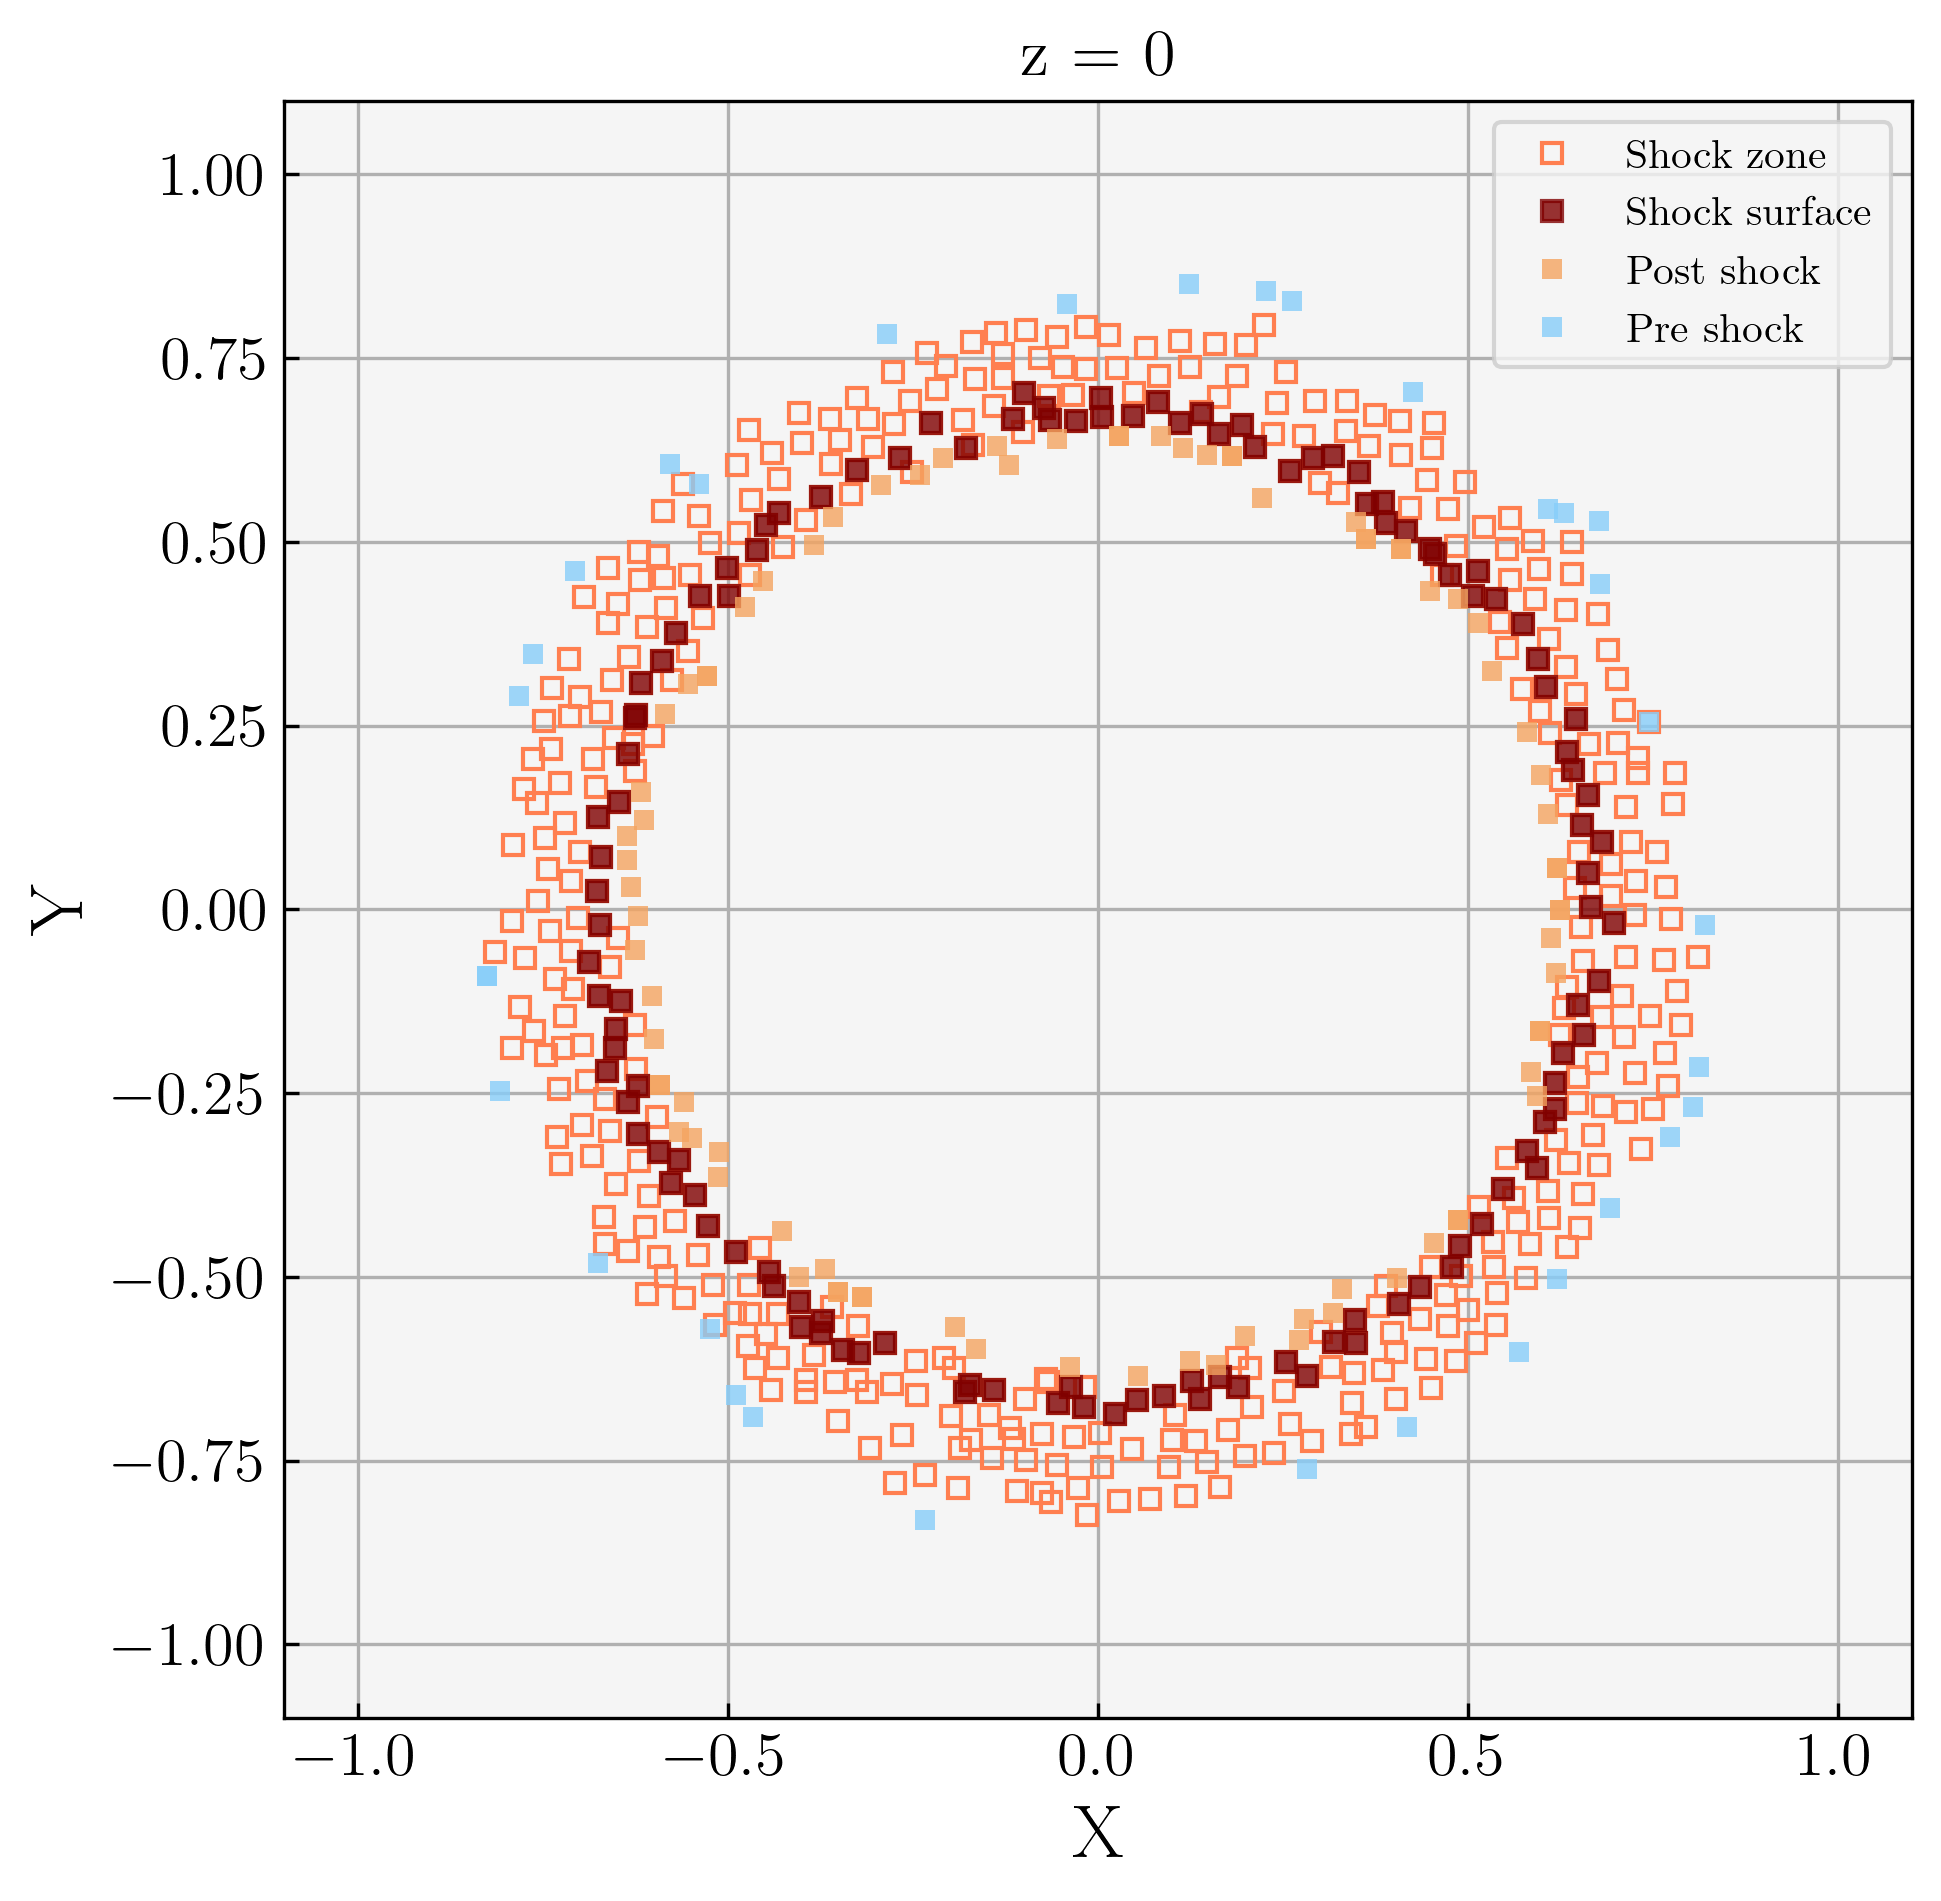

In [15]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (7,7))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
    ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 5, markeredgecolor='maroon',  alpha = 0.8, label = 'Shock surface')

    #ax.quiver(surface_cross_x, surface_cross_y, cross_shockdirx, cross_shockdiry, color = 'k', angles='xy', scale_units='xy', scale = 2)
    ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
    ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')

    # ax.plot(surface_cross_x[outlier], surface_cross_y[outlier], 'ks', markerfacecolor='r', ms = 7, markeredgecolor='r',  label = 'outlier')
    # ax.plot(post_x[slice_surface][outlier], post_y[slice_surface][outlier], 'ks', markerfacecolor='orange', ms = 7, markeredgecolor='orange',  label = 'outlier post')
    # ax.plot(pre_x[slice_surface][outlier], pre_y[slice_surface][outlier], 'ks', markerfacecolor='b', ms = 7, markeredgecolor='b',  label = 'outlier pre')

    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.legend()
    ax.set_title(f'z = {z_chosen}', fontsize = 16)
    plt.grid()
    if save == True:
        plt.savefig(f'Figs/{snap}/5shocksurface_z{z_chosen}_{snap}.png')
    plt.show()

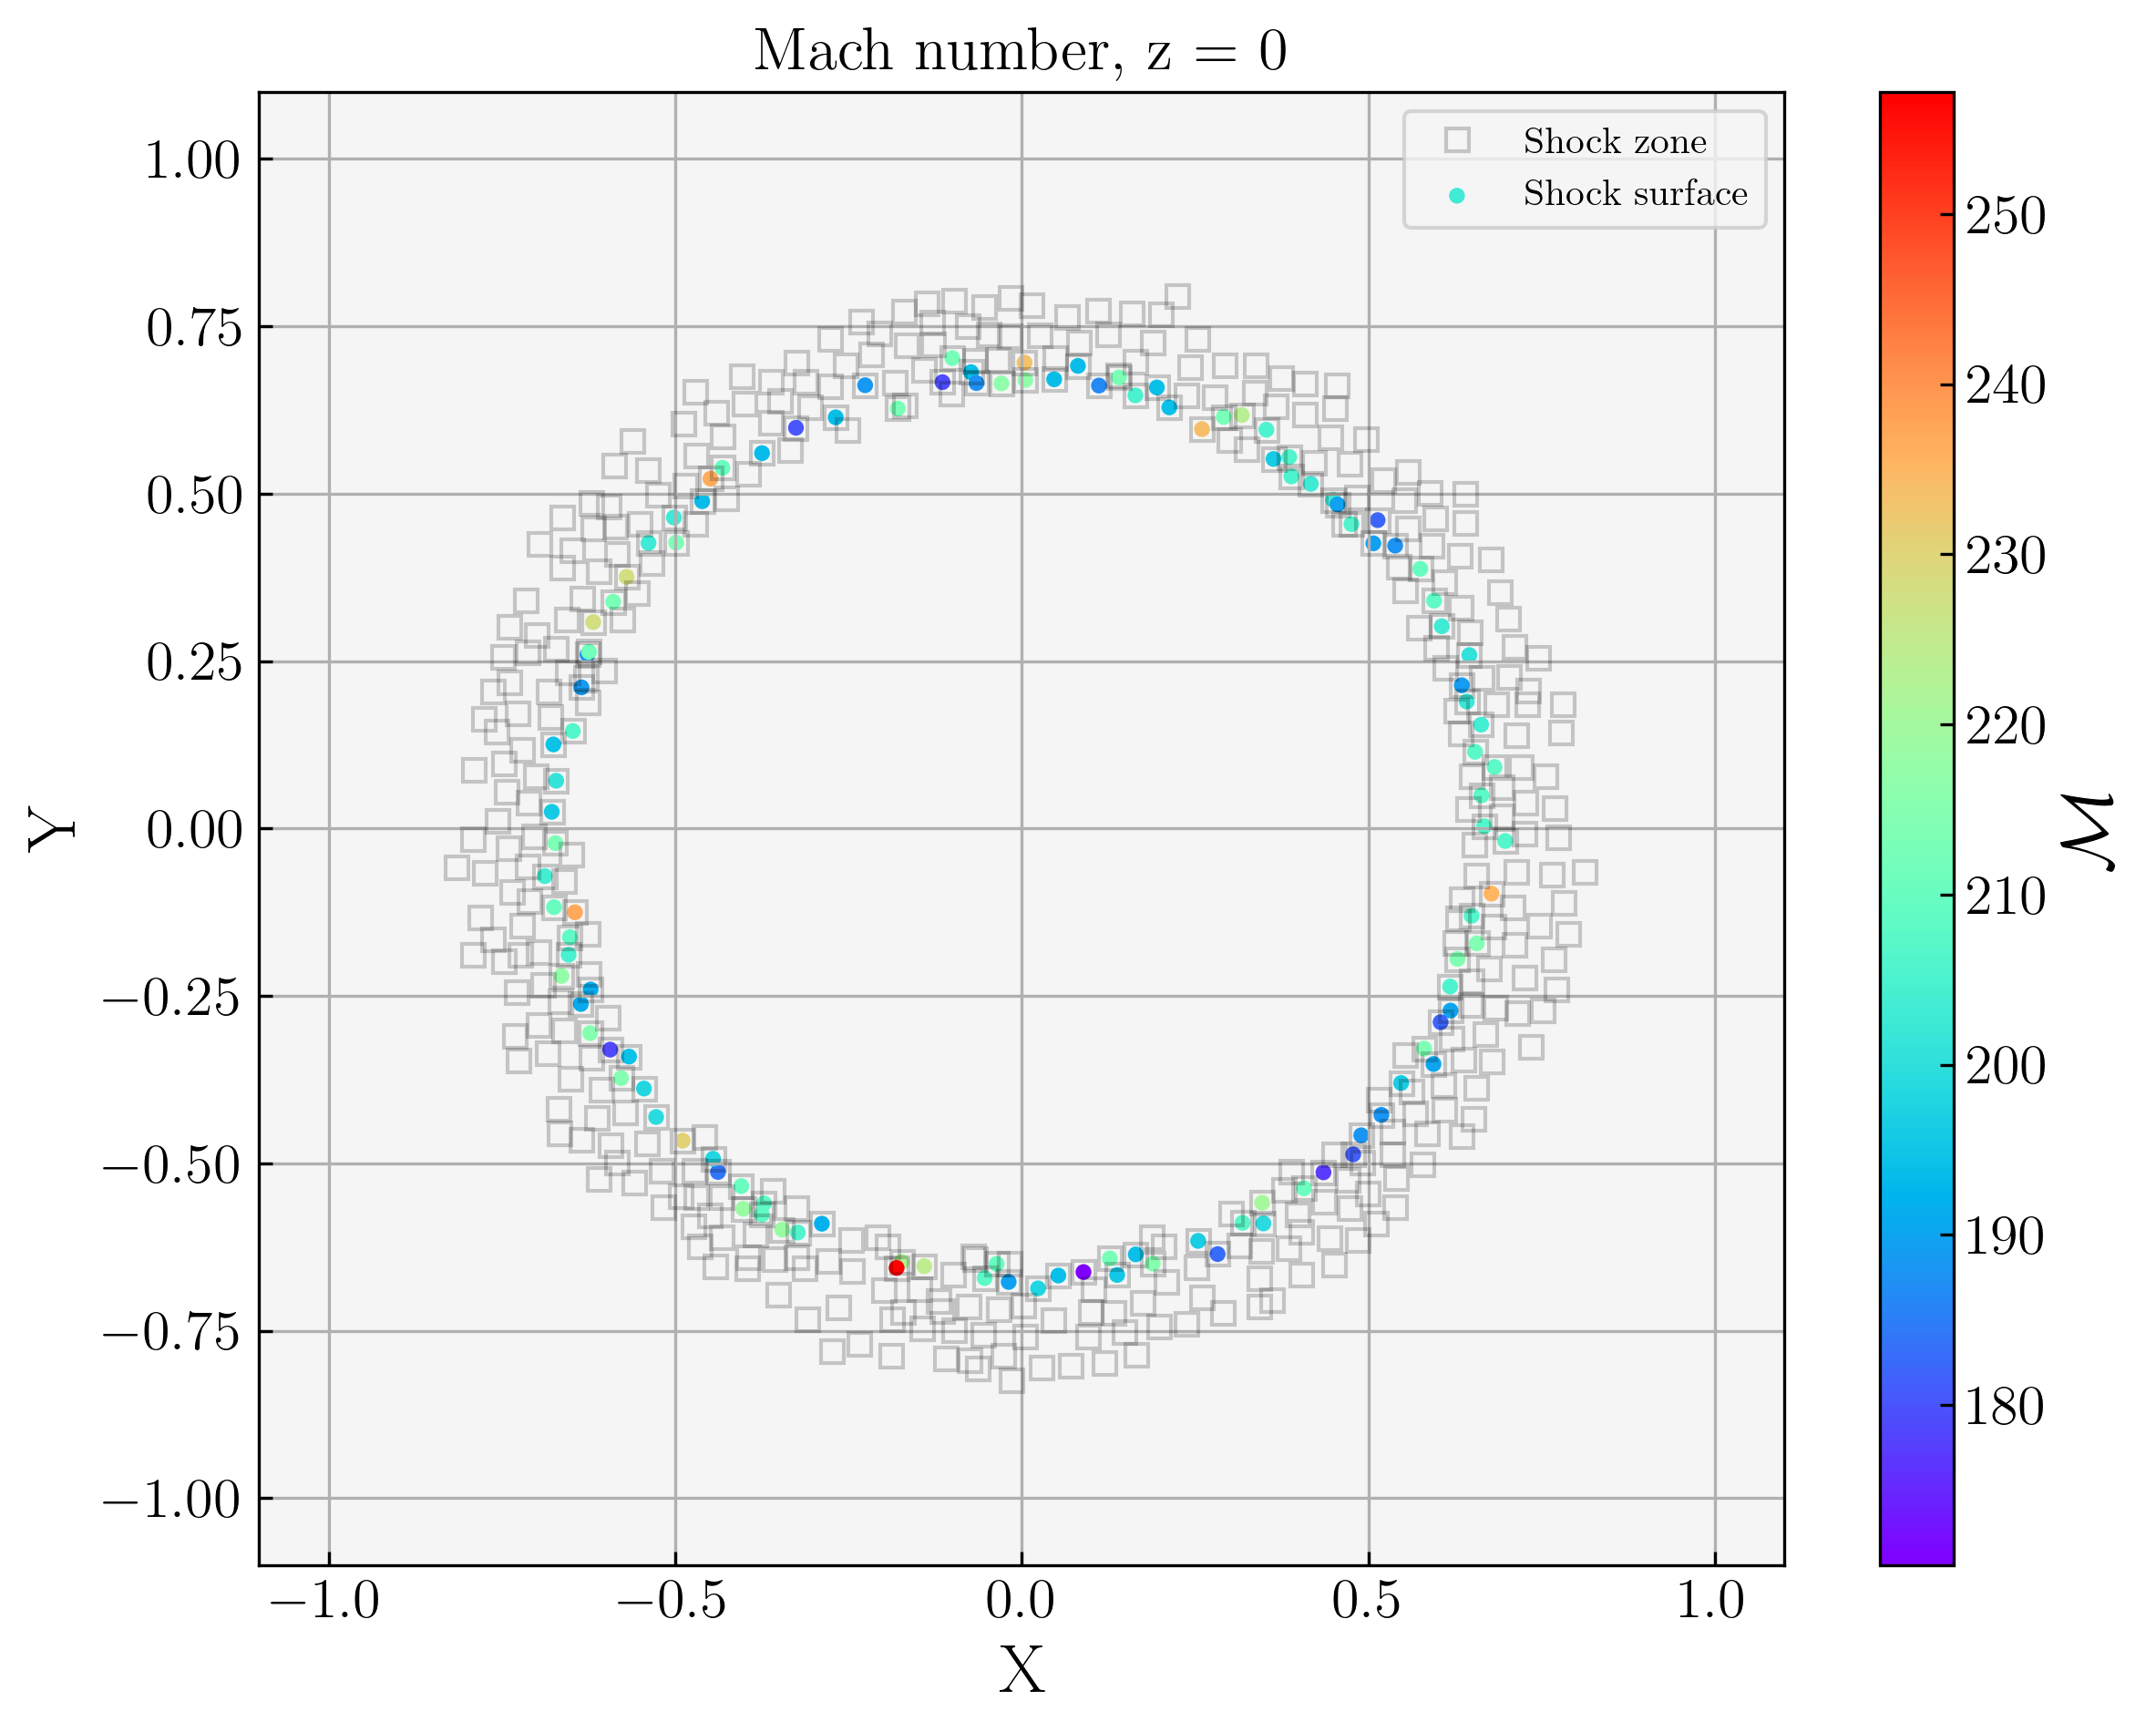

In [16]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
fig, ax = plt.subplots(1,1, figsize = (9,7))
if folder == 'sedov':
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.2, label = 'Shock zone')
    img = ax.scatter(surface_cross_x, surface_cross_y, c = surface_mach[slice_surface], s=10,  cmap = 'rainbow', label = 'Shock surface')#, vmin = 110, vmax = 160)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.set_title(f'Mach number, z = {z_chosen}', fontsize = 16)
else: 
    img = ax.scatter(surface_x/20_000, surface_y/20_000, c = surface_mach, label = 'Shock surface', cmap = 'rainbow')#, vmin=0, vmax = 5)
    #plt.plot(x_zone/20_000, y_zone/20_000, 'ks',  markerfacecolor='none', ms=5, markeredgecolor='k', label = 'shock zone')
    plt.ylim(-0.3, 0.2)
    plt.xlim(-1,0.05)
    plt.xlabel(r'X [x/$R_a$]', fontsize = 18)
    plt.ylabel(r'Y [x/$R_a$]', fontsize = 18)
cbar = plt.colorbar(img)
cbar.set_label(r'$\mathcal{M}$', fontsize = 19)
ax.legend()
plt.grid()
if save == True:
    plt.savefig(f'Figs/{snap}/5shocksurfaceMach_z{z_chosen}_{snap}.png')
plt.show()